In [3]:
import sys
get_ipython().system('{sys.executable} -m pip install --quiet numpy pandas matplotlib seaborn scikit-learn')

# Color Moments

In [41]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.manifold import MDS
from PIL import Image



### Setup

Crop automatico per isolare il cervello - Task1-2

In [5]:
def crop_to_brain(img):
    """Ritaglia l'area informativa (cervello) da un'immagine."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return img[y:y+h, x:x+w]
    return img  # fallback

In [6]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "color_moments_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "color_moments_part2.npz")



# Task 1-2

Implementa un programma che **estrae e memorizza i descrittori di feature** per tutte le immagini nel set di dati.

In [7]:
def extract_color_moments(img_path):
    """Estrae Color Moments su una griglia 10x10 da un'immagine."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata: {img_path}")
        return None

    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)
    img = cv2.resize(img, (300, 100))  # Griglia uniforme

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    for i in range(10):
        for j in range(10):
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            for channel in range(3):
                pixels = cell[:, :, channel].flatten()
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)
                    std = np.std(pixels)
                    sk = skew(pixels)
                    if np.isnan(sk): sk = 0
                else:
                    mean, std, sk = 0, 0, 0
                features.extend([mean, std, sk])
    return features

In [8]:
def process_and_save_features(base_folder, subfolders, output_file):
    """Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz."""
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_color_moments(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

In [9]:
# Parametri
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "color_moments_part1.npz")
process_and_save_features("Part2", subfolders, "color_moments_part2.npz")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in color_moments_part1.npz
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in color_moments_part2.npz


### Task 3

Implementa un programma che, **dato il **nome di un file immagine** e un valore "k"**, **restituisce e visualizza le k immagini più simili** in base a ciascun modello visivo

In [10]:
def find_k_similar_unified(base_folder, img_path, k, distance_type="euclidean"):
    """
    Trova le k immagini più simili a una query utilizzando distanza euclidea o Mahalanobis.
    
    Args:
        base_folder (str): Cartella base in cui cercare le immagini.
        img_path (str): Percorso immagine query.
        k (int): Numero di immagini da restituire.
        distance_type (str): Tipo di distanza ('euclidean' o 'mahalanobis').
    """
    # Estrai le feature dalla query
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    if distance_type == "euclidean":
        distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()

    elif distance_type == "mahalanobis":
        # Calcola matrice di covarianza e la sua inversa
        cov = np.cov(feat_matrix_part1.T)
        try:
            cov_inv = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            print("[ERRORE] Uso pseudoinversa per matrice non invertibile.")
            cov_inv = np.linalg.pinv(cov)

        query_feature = query_feature.flatten()
        distances = np.array([mahalanobis(query_feature, f, cov_inv) for f in feat_matrix_part1])

        # Escludi la query stessa se già presente
        query_filename = os.path.basename(img_path)
        query_label = os.path.basename(os.path.dirname(img_path))
        for i in range(len(flname_part1)):
            if flname_part1[i] == query_filename and lbls_part1[i] == query_label:
                distances[i] = np.inf
                break
    else:
        print(f"[ERRORE] Tipo di distanza non supportato: {distance_type}")
        return

    # Trova i top-k
    top_k_idx = np.argsort(distances)[:k]

    # Output testuale
    print(f"\nTop {k} immagini simili a: {img_path} (Distanza: {distance_type})")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank + 1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {distances[idx]:.2f}")

    # Visualizzazione immagini
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match_path = os.path.join(base_folder, lbls_part1[idx], flname_part1[idx])
        img_match = cv2.imread(img_match_path)
        axs[i + 1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i + 1}\nD={distances[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


Top 5 immagini simili a: Part1/brain_glioma/brain_glioma_0005.jpg (Distanza: euclidean)
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 49.20
3. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 50.50
4. brain_glioma_0767.jpg | Classe: brain_glioma | Distanza: 286.61
5. brain_glioma_0069.jpg | Classe: brain_glioma | Distanza: 355.25


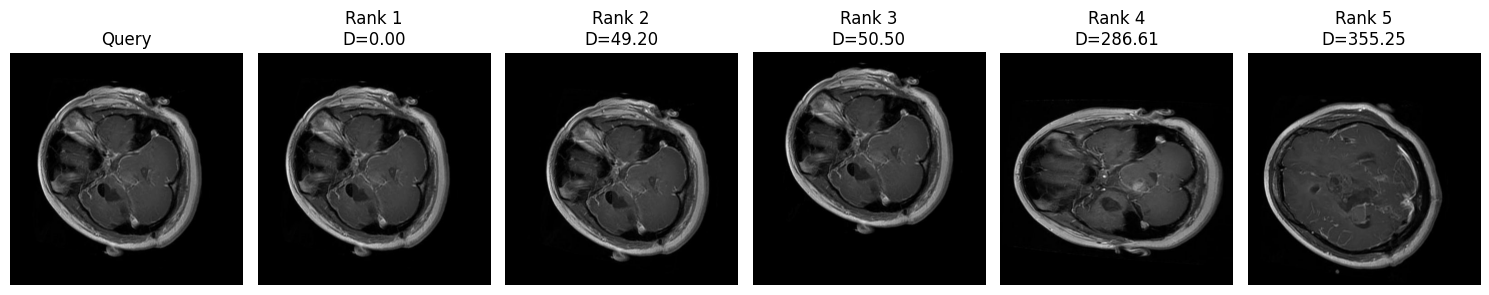

[ERRORE] Uso pseudoinversa per matrice non invertibile.

Top 5 immagini simili a: Part1/brain_glioma/brain_glioma_0005.jpg (Distanza: mahalanobis)
1. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 8.52
2. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 9.34
3. brain_glioma_0767.jpg | Classe: brain_glioma | Distanza: 17.61
4. brain_tumor_0369.jpg | Classe: brain_tumor | Distanza: 19.65
5. brain_glioma_0491.jpg | Classe: brain_glioma | Distanza: 20.40


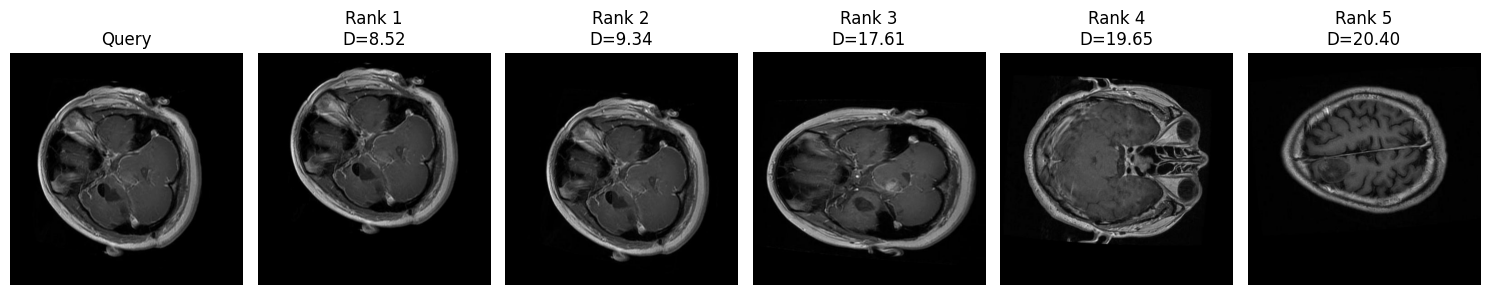

In [11]:
base_folder = "Part1"
img_path = "Part1/brain_glioma/brain_glioma_0005.jpg"

find_k_similar_unified(base_folder, img_path, k=5, distance_type="euclidean")
find_k_similar_unified(base_folder, img_path, k=5, distance_type="mahalanobis")

# Task 4

Implementa un programma che, dati:
- (a) un'immagine di query della **Parte 2**,
- (b) uno **spazio di feature** selezionato dall'utente,
- (c) un numero intero positivo **k**,

identifichi ed elenchi le **k etichette di corrispondenza più probabili**, insieme ai loro punteggi, calcolati nello **spazio di feature selezionato**.

---

## Requisiti

1. Accettare come input:
   - Un’immagine di query (da **Part2**),
   - Una scelta dell’utente sul tipo di **feature space**,
   - Un valore intero **k** (con **k ≤ 2**).

2. Calcolare le **feature** dell’immagine di query secondo lo **spazio di feature selezionato**.

3. Calcolare la distanza tra la query e tutte le immagini del dataset, utilizzando una metrica come:
   - **Distanza Euclidea**,
   - **Distanza di Mahalanobis**.

4. Raggruppare le distanze per **etichetta** e selezionare le **k classi più simili**, ad esempio calcolando:
   - la **distanza media**,
   - oppure la **somma inversa delle distanze**.

5. Stampare o restituire una **classifica delle k etichette più probabili**, con il rispettivo punteggio.

---

## Definizioni

**Feature space:** spazio vettoriale in cui ogni immagine è rappresentata come un **vettore di caratteristiche** (feature vector).

**Selected feature space:** indica **il tipo di caratteristiche** estratte per rappresentare le immagini (es. color moments, HOG, deep features, ecc.).

In [12]:
def compare_label_ranking_strategies(query_img_path, k=2):
    """
    Confronta le etichette predette da due strategie:
    - distanza media per classe
    - distanza al rappresentante (prototipo) della classe
    Visualizza solo le top-k etichette con un grafico comparativo.
    Inoltre stampa quale strategia sembra migliore in base alla distanza top-1.
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_color_moments(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # ===== Strategia 1: distanza media per classe =====
    distances_all = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    df_all = pd.DataFrame({
        'label': lbls_part1,
        'distance': distances_all
    })
    mean_dists = df_all.groupby('label')['distance'].mean().sort_values()

    # ===== Strategia 2: distanza dal prototipo (centroide) =====
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1
    class_prototypes = df_features.groupby('label').mean().drop(columns=['label'], errors='ignore')
    proto_vectors = class_prototypes.values
    proto_labels = class_prototypes.index
    proto_dists = euclidean_distances(proto_vectors, query_feature).flatten()
    proto_dists_series = pd.Series(proto_dists, index=proto_labels).sort_values()

    # ===== Prendi le top-k etichette comuni =====
    top_k_mean = mean_dists.head(k)
    top_k_proto = proto_dists_series.head(k)

    union_labels = sorted(set(top_k_mean.index).union(set(top_k_proto.index)))

    # ===== Plot solo per le top-k etichette =====
    x = np.arange(len(union_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [mean_dists[label] for label in union_labels], width, label='Distanza Media')
    ax.bar(x + width/2, [proto_dists_series[label] for label in union_labels], width, label='Distanza Prototipo')

    ax.set_ylabel('Distanza')
    ax.set_title(f"Top-{k} Strategie - Query: {os.path.basename(query_img_path)}")
    ax.set_xticks(x)
    ax.set_xticklabels(union_labels)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Stampa i top-k risultati =====
    print("\n Top-k etichette per ciascuna strategia:\n")
    print("Strategia: Distanza Media")
    print(top_k_mean)

    print("\n Strategia: Prototipo di Classe")
    print(top_k_proto)

    # ===== Confronto top-1 =====
    top1_mean_label = top_k_mean.index[0]
    top1_mean_value = top_k_mean.iloc[0]
    top1_proto_label = top_k_proto.index[0]
    top1_proto_value = top_k_proto.iloc[0]

    print("\n==== Analisi della Strategia Migliore ====")
    if top1_mean_label == top1_proto_label:
        print(f"[OK] Entrambe le strategie concordano sulla classe '{top1_mean_label}'.")
        print(f" → Distanza media: {top1_mean_value:.4f}, distanza prototipo: {top1_proto_value:.4f}")
    else:
        print(f"[DIFFERENZA] Le strategie danno risultati diversi:")
        print(f" - Distanza Media: '{top1_mean_label}' con distanza {top1_mean_value:.4f}")
        print(f" - Prototipo: '{top1_proto_label}' con distanza {top1_proto_value:.4f}")
        if top1_mean_value < top1_proto_value:
            print(f" → [SCELTA SUGGERITA] Preferibile 'Distanza Media' ({top1_mean_label})")
        else:
            print(f" → [SCELTA SUGGERITA] Preferibile 'Prototipo' ({top1_proto_label})")

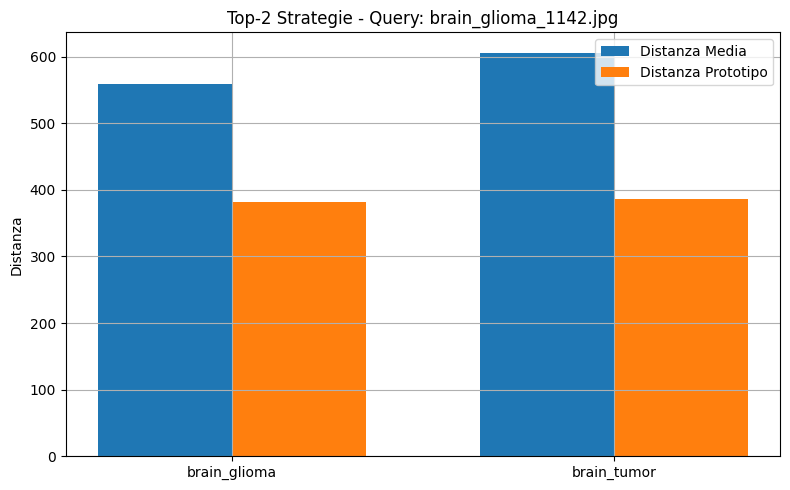


 Top-k etichette per ciascuna strategia:

Strategia: Distanza Media
label
brain_glioma    559.731457
brain_tumor     606.504738
Name: distance, dtype: float64

 Strategia: Prototipo di Classe
label
brain_glioma    381.972585
brain_tumor     386.868739
dtype: float64

==== Analisi della Strategia Migliore ====
[OK] Entrambe le strategie concordano sulla classe 'brain_glioma'.
 → Distanza media: 559.7315, distanza prototipo: 381.9726


In [13]:
query_img = "Part2/brain_glioma/brain_glioma_1142.jpg"
compare_label_ranking_strategies(query_img, k=2)

# Task 5: Estrazione delle Semantiche Latenti

Implementa un programma che, dati:
- (a) uno dei modelli di feature disponibili,
- (b) un valore **k** specificato dall'utente,
- (c) una delle tre tecniche di riduzione della dimensionalità (**SVD**, **LDA**, **k-means**) scelta dall'utente,

estragga le **prime k semantiche latenti** dallo spazio delle feature selezionato.

---

## Funzionalità richieste

- **Memorizzare** le semantiche latenti estratte in un file di output, **adeguatamente nominato**.
- **Elencare** per ogni componente latente le **coppie (imageID, peso)** ordinate in ordine decrescente di peso.

---

## Definizione del feature model

Il **feature model** è un file contenente la rappresentazione delle feature di tutte le immagini del dataset, salvato come matrice (`feature_matrix`).  
La matrice ha dimensioni **n × d**, dove:
- **n** = numero di immagini,
- **d** = numero di feature.

Esempio di feature model: `color_moments.npz`.

---

## Procedura

### Input
- Un **feature model** (es. `color_moments.npz`).
- Un valore **k** che indica il numero di componenti latenti da estrarre.
- Una tecnica di riduzione dimensionale (**SVD**, **LDA**, o **k-means**).

### Operazioni
1. **Riduzione dimensionale** del feature space selezionato tramite la tecnica scelta.
2. **Estrazione delle top-k componenti latenti**.
3. Per ogni componente:
   - Calcolare i **pesi** associati a ogni immagine.
   - Ordinare le coppie **(imageID, peso)** in ordine decrescente di peso.

4. **Salvare i risultati** in un file di testo con nome descrittivo, ad esempio:  
   `latent_semantics_svd_color_moments_k3.txt`.

---

## Significato di **k**

| Tecnica   | Significato di k                                           |
|-----------|------------------------------------------------------------|
| **SVD**   | Numero di componenti principali → riduzione mantenendo la variazione globale. |
| **LDA**   | Numero di direzioni discriminanti → riduzione focalizzata sulla separazione tra le classi. |
| **k-means** | Numero di cluster → suddivisione delle immagini in gruppi simili (senza usare le etichette). |

In [14]:

def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D delle immagini nello spazio latente (solo per SVD/LDA)."""
    print(f"[DEBUG] Shape X_svd (dati trasformati): {X_transformed.shape}")
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza le immagini raggruppate da KMeans su uno spazio 2D ridotto con SVD."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()

def task5_latent_semantics(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature usando SVD, LDA o KMeans.
    Visualizza lo spazio latente ed esporta un file .txt con i pesi associati alle immagini.
    """

    technique = technique.lower()
    method = ""
    X_transformed = None
    components = None

    if technique == "svd":
        model = TruncatedSVD(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # Visualizzazione
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)

# Creazione output
    output_dir = os.path.join("task5_output", "latent_semantics_color_moments")
    os.makedirs(output_dir, exist_ok=True)
    
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = os.path.join(output_dir, f"latent_semantics_{method}_{base_name}_k{k}.txt")

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feat_matrix_part1 @ components[i].T
                sorted_idx = np.argsort(-np.abs(weights))
            else:  # KMeans: distanza dal centroide, più piccola = più vicino
                weights = -X_transformed[:, i]
                sorted_idx = np.argsort(weights)

            for idx in sorted_idx:
                image_id = flname_part1[idx]
                f.write(f"{image_id} | Peso: {weights[idx]:.4f} | Classe: {lbls_part1[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")  

[DEBUG] Shape X_svd (dati trasformati): (3006, 2)


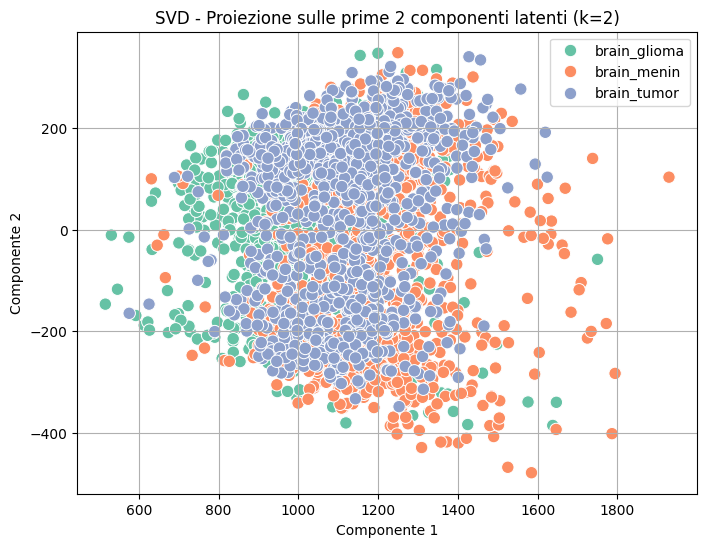

[SALVATO] Latent semantics salvati in: task5_output/latent_semantics_color_moments/latent_semantics_svd_color_moments_k2.txt
[DEBUG] Shape X_svd (dati trasformati): (3006, 2)


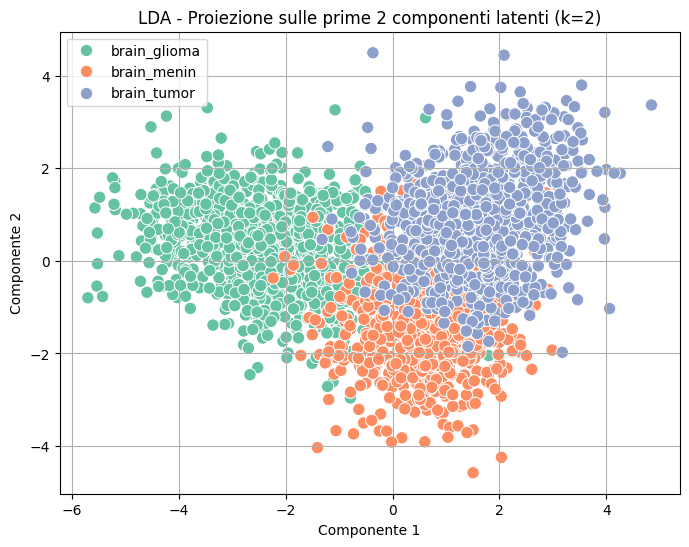

[SALVATO] Latent semantics salvati in: task5_output/latent_semantics_color_moments/latent_semantics_lda_color_moments_k2.txt


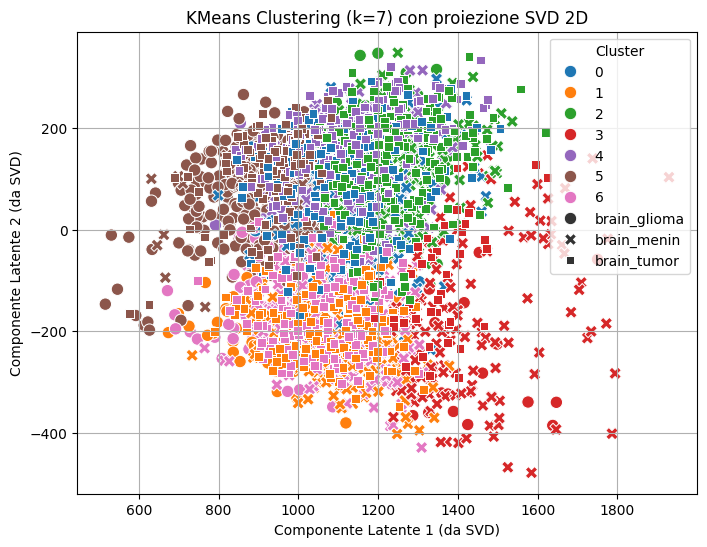

[SALVATO] Latent semantics salvati in: task5_output/latent_semantics_color_moments/latent_semantics_kmeans_color_moments_k7.txt


In [15]:
n_components=min(feat_matrix_part1.shape)

task5_latent_semantics("color_moments.npz", technique="svd", k=2)
#task5_latent_semantics("color_moments.npz", technique="svd", k=n_components)
task5_latent_semantics("color_moments.npz", technique="lda", k=2)
task5_latent_semantics("color_moments.npz", technique="kmeans", k=7)

# Task 6: Calcolo della Dimensionalità Intrinseca

## Obiettivo generale

Determinare la **dimensionalità intrinseca** degli spazi di feature, ossia il numero minimo di componenti latenti necessarie per spiegare una percentuale significativa della varianza dei dati.

Questa analisi permette di:
- Trasformare i dati in uno **spazio ortonormale**, mantenendo la maggior parte dell'informazione discriminante.
- **Ridurre la dimensionalità** dei dati senza perdere informazioni rilevanti.

---

## Descrizione dei sotto-task

### a) Dimensionalità intrinseca globale
Implementa un programma che:
- Calcola la **dimensionalità intrinseca complessiva** delle immagini della **Parte 1**.
- Riporta il numero minimo di componenti che spiegano una soglia predefinita di varianza (es. 95%).

---

### b) Dimensionalità intrinseca per classe
Implementa un programma che:
- Calcola la **dimensionalità intrinseca separatamente per ciascuna etichetta unica** delle immagini della **Parte 1**.
- Riporta il numero minimo di componenti che spiegano la soglia di varianza scelta (es. 95%) per ciascuna classe.

---

## Concetti chiave

###  Trasformazione latente ortonormale
- Utilizza tecniche di riduzione dimensionale (ad esempio **PCA**) per trasformare i dati in uno spazio le cui componenti sono ortonormali e ordinate per varianza spiegata.

###  Concentrazione dell'informazione
- Le prime componenti spiegano la maggior parte della varianza.
- Le componenti successive contengono informazioni progressivamente meno significative.

###  Dimensionalità intrinseca
- Definisce il **numero minimo di componenti** necessarie per spiegare almeno una certa percentuale della varianza (**threshold**, es. 95%).
- Se il numero di componenti latenti estratte (**m**) è uguale al numero di feature originali, la trasformazione conserva tutta l'informazione.
- Se la dimensionalità intrinseca è minore, si introduce un'**approssimazione controllata** nelle distanze e negli angoli dello spazio trasformato.


---

### explained = pca.explained_variance_ratio_
es. explained = [0.40, 0.30, 0.20, 0.07, 0.03]

Un **array di float** dove ciascun **valore rappresenta la percentuale di varianza spiegata da ciascuna componente principale della PCA**.
È ordinato dalla componente più importante a quella meno importante.

Significa che **la prima componente spiega il 40% della varianza**, la seconda il 30%, ecc.

### cumulative = np.cumsum(explained)
es:cumulative = [0.40, 0.70, 0.90, 0.97, 1.00]

Calcola la somma cumulativa dell’array explained, cioè la **varianza totale spiegata fino a ciascuna componente**.

Significa:
- Le prime 2 componenti spiegano il 70%
- Le prime 3 il 90%
- Le prime 4 il 97%, ecc.

### intrinsic_dim = np.argmax(cumulative >= threshold) + 1

Questa riga:
	- Trova il primo indice in cui la varianza cumulativa raggiunge o supera una soglia (threshold), ad esempio 0.95 (95%).
	- np.argmax(...) restituisce il primo True nella condizione cumulative >= threshold.
	- Si aggiunge +1 perché gli indici Python partono da 0, ma il numero di componenti parte da 1.



In [16]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [17]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


\Stima automatica di k in base alla varianza spiegata:

[INFO] Feature matrix shape: (3006, 900)
[INFO] k ottimale suggerito (soglia 90%): 66
Soglia 90% : k = 66
[INFO] k ottimale suggerito (soglia 95%): 102
Soglia 95% : k = 102
[INFO] k ottimale suggerito (soglia 99%): 167
Soglia 99% : k = 167


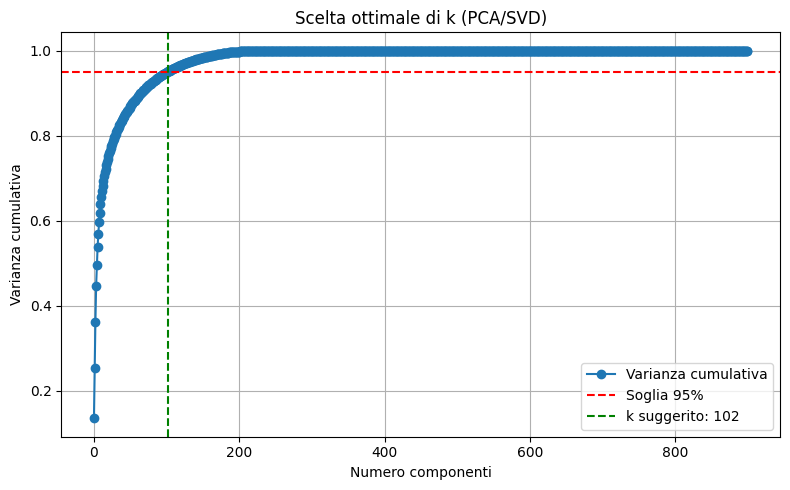

[INFO] k ottimale suggerito (soglia 95%): 102

 Task 6b – Dimensionalità per etichetta:

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 91
 Label 'brain_glioma' : k = 91
[INFO] k ottimale suggerito (soglia 95%): 94
 Label 'brain_menin' : k = 94
[INFO] k ottimale suggerito (soglia 95%): 93
 Label 'brain_tumor' : k = 93


In [18]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

# Task 7

Implementare un programma che:

1. Per ogni etichetta unica **l**, calcoli le corrispondenti **k componenti semantiche latenti** (a scelta) associate alle immagini della **Parte 1**.
2. Per le immagini della **Parte 2**, preveda le etichette più probabili utilizzando le **distanze/similarità calcolate nello spazio semantico latente specifico per ciascuna etichetta**.

Il sistema deve inoltre calcolare e riportare:
- **Precisione (Precision)** per ciascuna classe,
- **Richiamo (Recall)** per ciascuna classe,
- **Punteggio F1 (F1-score)** per ciascuna classe,
- **Accuratezza complessiva (Accuracy)**.

---

## 1. Estrazione della semantica latente per ogni classe

**Funzione:** `compute_latent_semantics_per_class(X, y, k)`

### Input
- `X`: Matrice delle feature delle immagini della Parte 1.
- `y`: Vettore delle etichette corrispondenti.
- `k`: Numero di componenti latenti da estrarre (ad esempio tramite SVD).

### Output
- `class_models`: Dizionario che, per ogni classe, contiene:
  - uno **scaler** per la normalizzazione delle feature,
  - il modello **SVD**,
  - i vettori latenti della classe.
- `class_means`: Vettori medi (**centroidi latenti**) per ciascuna classe.

---

## 2. Predizione delle etichette

**Funzione:** `predict_label(X_test, class_models, class_means)`

### Input
- `X_test`: Matrice delle feature delle immagini da classificare (Parte 2).
- `class_models`: Modelli latenti per ciascuna classe.
- `class_means`: Centroidi latenti di ciascuna classe.

### Output
- `y_pred`: Lista delle etichette previste per ciascuna immagine.

---

## 3. Valutazione delle prestazioni

**Funzioni:** `evaluate(y_true, y_pred)` oppure `evaluate_predictions(true_labels, predicted_labels)`

### Metriche calcolate
- **Precisione** per classe.
- **Recall** per classe.
- **F1-score** per classe.
- **Accuratezza complessiva.**

---

## Concetto chiave

Ogni classe ha un **proprio spazio semantico latente**, in cui le immagini della classe sono rappresentate in modo compatto.  
Quando un'immagine deve essere classificata:
- viene proiettata in ogni spazio latente di classe,
- viene calcolata la distanza rispetto al **centroide latente** di ciascuna classe,
- l'immagine viene assegnata alla classe il cui centroide è il più vicino.

In [19]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [20]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.55, R=0.41, F1=0.47
Class brain_menin: P=0.46, R=0.59, F1=0.52
Class brain_tumor: P=0.30, R=0.30, F1=0.30

Overall Accuracy: 0.43

              precision    recall  f1-score   support

brain_glioma       0.55      0.41      0.47      1002
 brain_menin       0.46      0.59      0.52      1002
 brain_tumor       0.30      0.30      0.30      1002

    accuracy                           0.43      3006
   macro avg       0.44      0.43      0.43      3006
weighted avg       0.44      0.43      0.43      3006



# Task 8

Implementa un programma che, per ciascuna etichetta univoca **l**, calcoli i **c cluster più significativi** associati alle immagini della **Parte 1**, utilizzando l'algoritmo **DBSCAN**.

I cluster risultanti devono essere visualizzati in due modalità:
- Come **nuvole di punti** colorate in modo diverso, proiettate in uno spazio a **2 dimensioni** tramite **MDS (Multidimensional Scaling)**.
- Come **gruppi di miniature di immagini**, dove ogni gruppo rappresenta un cluster distinto.

In [42]:
def apply_dbscan_with_pca(features, eps=2.0, min_samples=3, n_components=50):
    """
    Riduce 'features' a 'n_components' dimensioni con PCA, quindi applica DBSCAN
    e restituisce l'array di cluster-labels (interi) di lunghezza = numero di righe in 'features'.
    """
    print(f"[INFO] PCA -> Riduzione a {n_components} componenti")
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels


def top_c_clusters(cluster_labels, c):
    """
    cluster_labels: array di interi di lunghezza N.
    c: numero di cluster "più popolosi" che vogliamo restituire.
    Restituisce la lista dei c valori di cluster (escludendo -1) 
    ordinati in base alla dimensione (numero di occorrenze) decrescente.
    Se DBSCAN ha trovato meno di c cluster, restituisce tutti quelli disponibili.
    """
    # Conteggio delle occorrenze per ogni etichetta di cluster
    label_counts = Counter(cluster_labels)
    # Rimuovo il rumore (-1) se presente
    label_counts.pop(-1, None)
    
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i c cluster più frequenti
    most_common = label_counts.most_common(c)  # es. [(label1, count1), (label2, count2), ...]
    top = [int(lbl) for lbl, _ in most_common]
    
    # Se DBSCAN ha trovato meno di c cluster, most_common contiene già tutti
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


def plot_mds_clusters(features, cluster_labels, top_clusters, metric='euclidean'):
    """
    features: array (N, d) delle tue feature originali (senza aver fatto PCA).
    cluster_labels: array (N,) con i risultati DBSCAN.
    top_clusters: lista di interi pari ai cluster "significativi" (col più grandi).
    metric: la distanza da usare per MDS (default 'euclidean').
    Mostra un grafico 2D (scatter) con i punti appartenenti ai top_clusters colorati diversamente,
    tutti gli altri (cluster minori o -1) in grigio chiaro.
    """
    # 1) Normalizzo / scalizzo le features originali
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 2) Calcolo la matrice di distanze (facoltativo) e poi MDS → Y (N×2)
    #    Qui usiamo MDS “direttamente” su features_scaled, che di default assume euclidea.
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    Y = mds.fit_transform(features_scaled)

    # 3) Plotto i punti
    import matplotlib
    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)

    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()


def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16‐25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)


            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()



[INFO] Elaboro label: brain_glioma
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1  2]
[INFO] Top 3 cluster (per dimensione): [1, 2, 0]
[INFO] Disegno MDS 2D per i cluster di 'brain_glioma' …


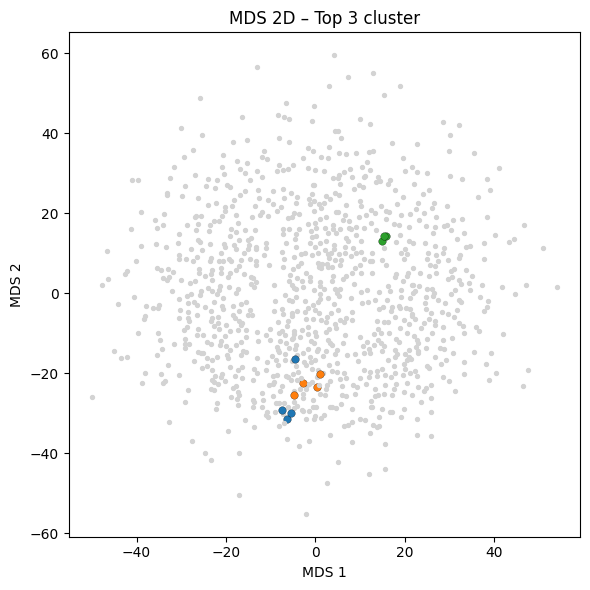

[INFO] Genero miniature per ciascun cluster di 'brain_glioma' …
[INFO] Cluster 1: 4 immagini trovate


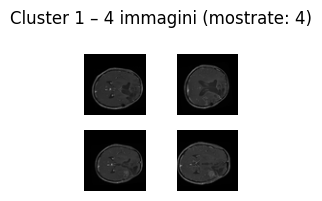

[INFO] Cluster 2: 4 immagini trovate


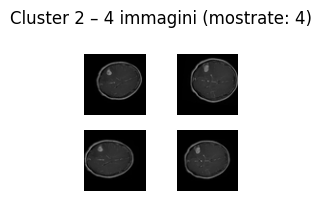

[INFO] Cluster 0: 3 immagini trovate


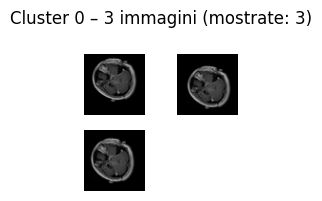


[INFO] Elaboro label: brain_menin
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0  1]
[WARN] DBSCAN ha trovato solo 2 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [1, 0]
[INFO] Disegno MDS 2D per i cluster di 'brain_menin' …


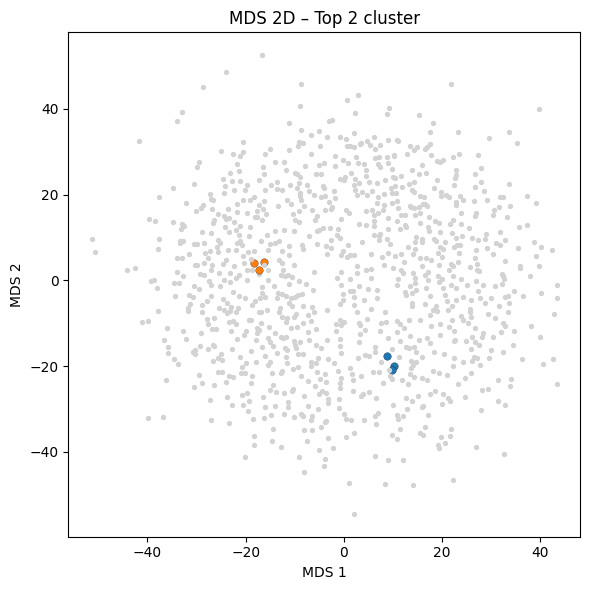

[INFO] Genero miniature per ciascun cluster di 'brain_menin' …
[INFO] Cluster 1: 3 immagini trovate


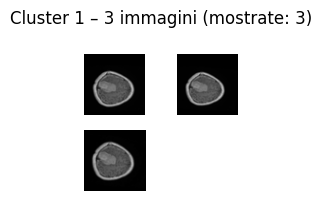

[INFO] Cluster 0: 3 immagini trovate


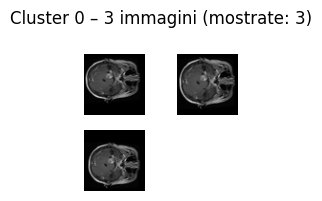


[INFO] Elaboro label: brain_tumor
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1  0]
[WARN] DBSCAN ha trovato solo 1 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [0]
[INFO] Disegno MDS 2D per i cluster di 'brain_tumor' …


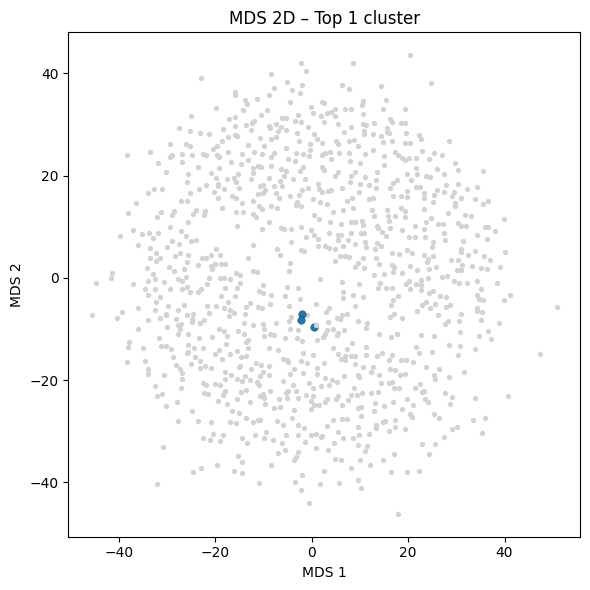

[INFO] Genero miniature per ciascun cluster di 'brain_tumor' …
[INFO] Cluster 0: 3 immagini trovate


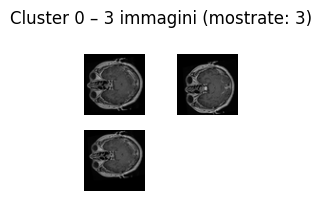


[FINITO] Task 8 completato per tutte le label di Parte1.


In [43]:
# ================================
# BLOCCHETTO PER TASK 8 (RIUSO FUNZIONI)
# ================================

# 3) PARAMETRI (modificabili a piacere)
eps = 2.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label

# 4) Creare una cartella di output (facoltativo)
output_base = "./results_task8"
os.makedirs(output_base, exist_ok=True)

# 3) Costruisco l’elenco dei full path per tutte le immagini
base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
images_full = [ os.path.join(base_folder, lbl, fname)
                for fname, lbl in zip(flname_part1, lbls_part1) ]

# 5) SCORRO OGNI LABEL DI Parte1 E APPLICO DBSCAN+PCA
unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

for lbl in unique_labels:
    print(f"\n==============================")
    print(f"[INFO] Elaboro label: {lbl}")
    print(f"==============================")

    # 5.1) Estraggo le righe di feat_matrix_part1 / flname_part1 corrispondenti
    mask_lbl = (lbls_part1 == lbl)
    features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
    images_label   = np.array(images_full)[mask_lbl]

    # 5.2) Chiamo la tua funzione che fa PCA + DBSCAN
    cluster_labels = apply_dbscan_with_pca(
        features_label,
        eps=eps,
        min_samples=min_samples,
        n_components=n_components
    )
    print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

    # 5.3) Trovo i c cluster più grandi
    top_clusters = top_c_clusters(cluster_labels, c)
    print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

    # 5.4) Creo sotto-cartella di output per questa label
    out_dir_lbl = os.path.join(output_base, f"label_{lbl}")
    os.makedirs(out_dir_lbl, exist_ok=True)

    # 5.5) MDS‐2D + scatter plot del clustering
    print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")
    # (ATTENZIONE: plot_mds_clusters in genere “fa plt.show()” a video.
    #  Se vuoi salvare l’immagine invece di far vedere a notebook, 
    #  devi modificare leggermente quella funzione per usare plt.savefig())
    plot_mds_clusters(
        features_label,
        cluster_labels,
        top_clusters,
        metric='euclidean'
    )
    # Se invece vuoi **salvare** l’immagine in PNG anziché fare “show()”:
    #    plt.savefig(os.path.join(out_dir_lbl, f"{lbl}_MDS_clusters.png"))
    #    plt.close()

    # 5.6) Creo le miniature di ogni cluster “significativo”
    print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
    show_cluster_thumbnails(
        images_label,      # array di stringhe di percorsi
        cluster_labels,    # array di int di lunghezza n_i
        top_clusters,      # la lista dei c indici di cluster
        thumb_size=(64, 64)
    )
    # Anche qui, di default quella funzione fa plt.show() per ogni cluster.
    # Se vuoi salvare le figure in file, modifica show_cluster_thumbnails in
    # modo che setti un outpath e faccia plt.savefig().

print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")


# Task 9: Classificazione m-NN e Decision Tree

Implementa un programma che, date le immagini della **Parte 1**:

- Crei un classificatore **m-NN** (con **m** specificato dall'utente).
- Crei un classificatore basato su **albero decisionale**.

Per questo task puoi utilizzare **lo spazio delle feature a tua scelta**.

Il programma deve poi:
- Applicare il classificatore selezionato dall'utente per prevedere le etichette più probabili delle immagini della **Parte 2**.
- Calcolare e visualizzare:
  - **Precisione (Precision)** per etichetta,
  - **Richiamo (Recall)** per etichetta,
  - **Punteggio F1 (F1-score)** per etichetta,
  - **Accuratezza complessiva (Accuracy)** del classificatore.

In [29]:
# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))

Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.78      0.85      0.81      1002
 brain_menin       0.84      0.63      0.72      1002
 brain_tumor       0.74      0.85      0.79      1002

    accuracy                           0.78      3006
   macro avg       0.78      0.78      0.77      3006
weighted avg       0.78      0.78      0.77      3006

Accuratezza complessiva m-NN: 0.7767797737857618
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.75      0.76      0.75      1002
 brain_menin       0.64      0.62      0.63      1002
 brain_tumor       0.71      0.72      0.71      1002

    accuracy                           0.70      3006
   macro avg       0.70      0.70      0.70      3006
weighted avg       0.70      0.70      0.70      3006

Accuratezza complessiva Decision Tree: 0.7005988023952096


# Task 10: Locality Sensitive Hashing e Ricerca di Immagini Simili

## 10a: Creazione dell'indice LSH

Implementa uno strumento di **Locality Sensitive Hashing (LSH)** (per la distanza euclidea), che prende come input:
- **L**: Numero di livelli,
- **h**: Numero di hash per livello,
- Un insieme di vettori (feature delle immagini).

Il programma deve creare **una struttura di indice in memoria** contenente l'insieme di vettori dato.

> Riferimento:  
> "Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions",  
> Alexandr Andoni e Piotr Indyk, *Communications of the ACM*, vol. 51, no. 1, 2008, pp. 117–122.

---

## 11b: Ricerca di immagini simili con LSH

Implementa un algoritmo di ricerca di immagini simili utilizzando la struttura LSH creata in 11a, memorizzando le immagini della **Parte 1** e un modello visivo di tua scelta (**il modello visivo combinato deve avere almeno 256 dimensioni**).

Per una data immagine di query e un numero intero **t**, il programma deve:

- Visualizzare le **t immagini più simili**.
- Mostrare:
  - Il **numero di immagini uniche** considerate,
  - Il **numero totale di immagini analizzate** durante il processo.

In [23]:
class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea con quantizzazione (p-stable).
    num_layers = L, num_hashes = h, dim = D, r = bucket width.
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        self.hash_tables = [defaultdict(list) for _ in range(self.L)]
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        bits = []
        for j in range(self.h):
            a_j = self.a_vectors[layer_idx][j]
            b_j = self.b_offsets[layer_idx][j]
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            bits.append(h_val)
        return tuple(bits)

    def index(self, vectors: np.ndarray):
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Dimensione vettore ({D}) ≠ D di LSH ({self.d})."
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        assert q_vec.shape[0] == self.d, "Dimensione query ≠ D."
        candidati = set()
        total_checked = 0
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


In [24]:
# 1) Center + L2 normalize su Part1
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH con quantizzazione
D = feat_normed.shape[1]      # ad esempio 900
L = 5                         # numero di layer (esempio)
h = 5                        # numero di hash per layer (esempio)
r = 5.0                       # bucket width, da sperimentare

# 3) Creo l'indice
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] Indice LSH-Quant creato. D={D}, L={L}, h={h}, r={r}")



[INFO] Indice LSH-Quant creato. D=900, L=5, h=5, r=5.0


In [25]:
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Trova le k immagini più simili a img_path (di Part2) usando lsh_quant costruito su Part1.
    """
    # 1) Estrai feature raw (900-dim)
    raw_q = np.array(extract_color_moments(img_path), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec usato su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampo i risultati testuali
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


Part2/brain_menin/brain_menin_1003.jpg

[LSH-Quant] Top 5 simili a: Part2/brain_menin/brain_menin_1003.jpg
  1. brain_glioma_0596.jpg | Classe: brain_glioma | Distanza Euclidea: 0.66
  2. brain_menin_0554.jpg | Classe: brain_menin | Distanza Euclidea: 0.87
  3. brain_tumor_0622.jpg | Classe: brain_tumor | Distanza Euclidea: 0.89
  4. brain_menin_0585.jpg | Classe: brain_menin | Distanza Euclidea: 0.93
  5. brain_menin_0520.jpg | Classe: brain_menin | Distanza Euclidea: 0.93
[LSH-Quant] Immagini uniche considerate: 2442
[LSH-Quant] Immagini totali controllate: 4055


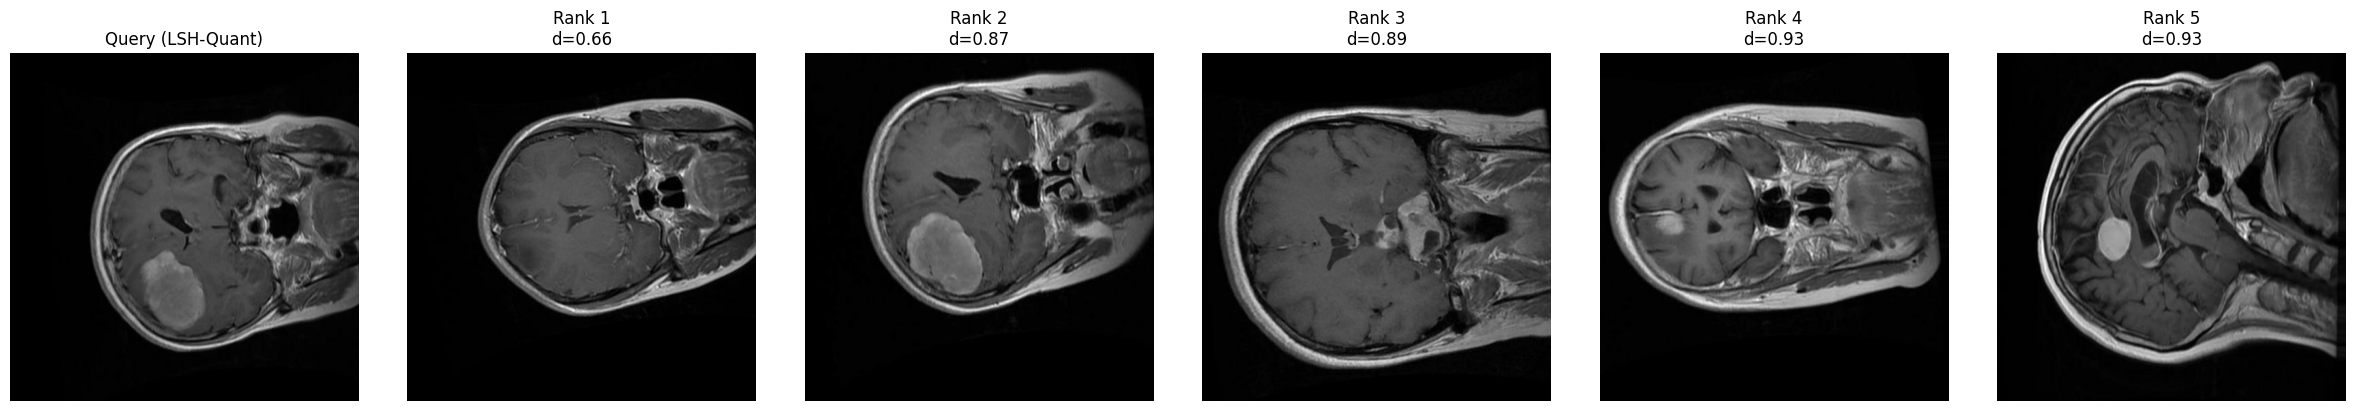

In [26]:
# Utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_menin/brain_menin_1003.jpg"

print(query_path);
k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)
